# Early Data Analysis
Interpreting data from `batch_analyse.py`. The aim is to filter out the dataset to the required properties to explore potential exocomet-type transits.

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import data
import os
from astropy.table import Table, unique
from analysis_tools_cython import *
from post_processing_tools import *
from tqdm import tqdm

In [3]:

plt.rcParams['figure.figsize'] = (11.0, 8.0)
plt.rcParams['font.size'] = 16
# plt.rcParams('xtick', labelsize='medium')
# plt.rcParams('ytick', labelsize='medium')

---

### Functions

---

## Creating DataFrame
- data used is `corrected flux`, not PCA.

In [4]:
df = get_output('output_log_xrp/output_s6_008_twostep.txt')
filtered_df = filter_df(df)

df_05 = get_output('output_log_xrp/output_s6_005_twostep.txt')
filtered_df_05 = filter_df(df_05)

df_onestep = get_output('output_log_xrp/output_onestep_008_s6.txt')

df_onestep_05 = get_output('output_log_xrp/output_onestep_005_s6.txt')

In [5]:
df['transit_prob'].unique()

array(['end', 'maybeTransit', 'artefact', 'point'], dtype=object)

`filtered_df` with `maybeTransit` only

In [6]:
filtered_df[filtered_df.transit_prob == 'maybeTransit']

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
1488,tesslc_139539915.pkl,-17.670788,-5.338849,1473.433105,1.164229,0.350133,0.003305,0.520826,-0.059722,maybeTransit
2646,tesslc_72915652.pkl,-6.192280,-5.349773,1476.474487,1.009722,0.295413,0.003453,0.562491,-0.006072,maybeTransit
6783,tesslc_282906780.pkl,-9.001791,-5.041697,1476.036743,1.003514,0.336423,0.129218,0.666676,-0.015419,maybeTransit
7702,tesslc_714092804.pkl,-16.523638,-5.416274,1473.412354,1.162059,0.085437,0.249504,0.541659,-0.026874,maybeTransit
8031,tesslc_139591778.pkl,-19.919554,-5.393875,1473.412354,1.001922,0.370047,0.009652,0.541659,-0.070949,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
2045761,tesslc_370221320.pkl,-8.720510,-5.409797,1476.072632,1.017462,0.285593,0.081998,0.541663,-0.002586,maybeTransit
2052378,tesslc_461706520.pkl,-18.826302,-5.047062,1473.412354,1.166532,0.080631,0.261035,0.520829,-0.024455,maybeTransit
2053158,tesslc_247710545.pkl,-19.295509,-5.079751,1473.412476,1.043542,0.391747,0.009206,0.562491,-0.028259,maybeTransit
2056480,tesslc_177385976.pkl,-17.065828,-5.245050,1475.572876,1.003578,0.541441,0.112646,0.812507,-0.008745,maybeTransit


---

### Raw Plot

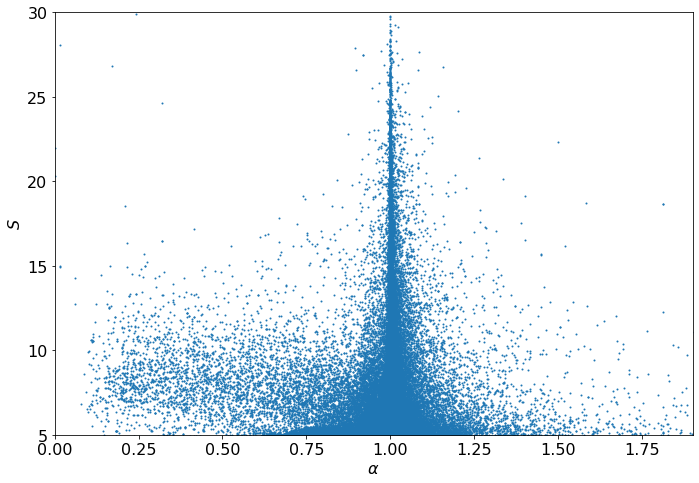

In [7]:
distribution(df.asym_score,abs(df['signal/noise']))

### `MaybeTransit` only

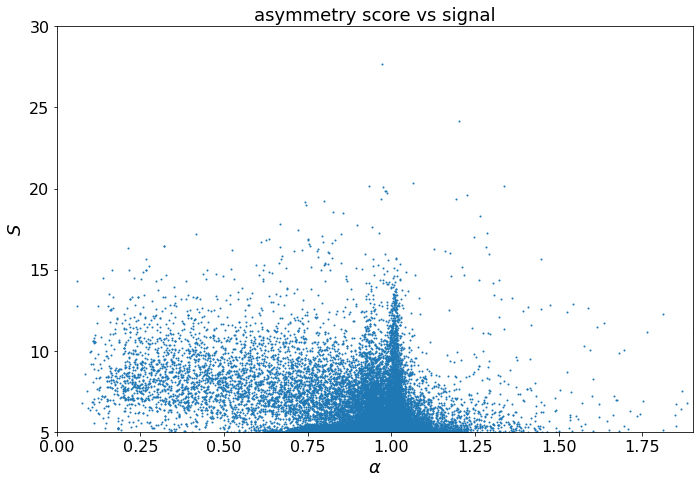

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(df.asym_score[df.transit_prob == 'maybeTransit'],abs(df['signal/noise'][df.transit_prob == 'maybeTransit']),s=1)
ax.set_xlim(0,1.9)
ax.set_ylim(5,30)
ax.set_xlabel('$\\alpha$',fontsize=18)
ax.set_ylabel('$S$',fontsize=18)
ax.set_title('asymmetry score vs signal',fontsize=18)
fig.tight_layout()
#rect = patches.Rectangle((1.30, 7.40), 0.25, 4, linewidth=3, edgecolor='k', facecolor='none')
#interest_region = patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none') # region of interest in Kennedy et al
#ax.add_patch(rect)
#ax.add_patch(interest_region)
plt.show()

Next steps - apply a feature that distinguishes false positives, EB's, etc.

---

---

### Exploring that black boxed region (S6)

Create our box with the following settings:
- `signal/noise` between 7.4 and 12
- `asym_score` between 1.3 and 1.6

In [9]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]

In [10]:
to_import = box[['file','asym_score','signal/noise']]
#example = box['file'].tail(25)

---

In [11]:
box

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
40771,tesslc_140508040.pkl,-12.437112,-7.981307,1473.224731,1.428987,0.104525,0.000019,0.208331,-0.062122,maybeTransit
218417,tesslc_139678180.pkl,-14.038894,-7.620009,1473.370728,1.404811,0.036554,0.075723,0.062499,-31.861950,maybeTransit
375419,tesslc_711920562.pkl,-17.738857,-8.794168,1476.182861,1.354627,0.048664,0.079720,0.104166,-0.016505,maybeTransit
438661,tesslc_302762566.pkl,-12.022918,-8.418746,1473.391602,1.325270,0.023620,0.202082,0.062499,-0.034191,maybeTransit
525446,tesslc_24701760.pkl,-15.705395,-7.928107,1472.765747,1.348174,0.076669,0.005131,0.124997,-0.033609,maybeTransit
764407,tesslc_151470359.pkl,-11.754588,-7.737175,1473.391602,1.373458,0.021583,0.150573,0.062499,-0.021218,maybeTransit
881899,tesslc_139678183.pkl,-14.051334,-7.619753,1473.370728,1.405997,0.036578,0.075525,0.062499,-31.985451,maybeTransit
917837,tesslc_281920897.pkl,-14.303375,-11.576231,1473.349731,1.417146,0.049523,0.005822,0.083332,-109.367752,maybeTransit
1090738,tesslc_281979601.pkl,-18.671787,-9.409482,1476.843140,1.374593,0.058594,0.004032,0.104169,-0.031182,maybeTransit
1267154,tesslc_370138494.pkl,-26.774765,-8.017654,1476.572388,1.323735,0.245000,0.041017,0.416660,-0.048994,maybeTransit


In [12]:
sector = 6
clip = 4
path = '/storage/astro2/phrdhx/tesslcs'
mad_df = data.load_mad()

#### Saving TIC paths

In [13]:
# for i in tqdm(to_import):
#     file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
#     ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
#     store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=False)[1]
#     tic = store[0]
#     ra = store[1]
#     dec = store[2]
#     to_export = [tic,ra,dec]
#     with open("weird_tic_path.txt", "a") as output:
#         output.write(file_paths+'\n')

---

In [14]:
for i in to_import['file']:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=4,drop_bad_points=True)
    camera = store[4]
    tic = store[0]

    chip = store[5]

#     mad_arr = mad_df.loc[:len(table['time'])-1,f"{sector}-{camera}"]
#     sig_clip = sigma_clip(mad_arr,sigma=clip,masked=True)
#     med_sig_clip = np.nanmedian(sig_clip)
#     rms_sig_clip = np.nanstd(sig_clip)
#     mad_cut = mad_arr.values < ~sig_clip.mask 
    

#     fig, ax = plt.subplots(2,2,figsize=(10,8))
#     ax[0,1].scatter(table['time'], mad_arr, s=2)
#     ax[0,1].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].scatter(range(0,len(table['time'])), mad_arr, s=2)
#     ax[0,0].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].axhline(med_sig_clip + clip*rms_sig_clip, c='r')
#     ax[0,0].set_title(f'S{sector}-C{camera}')
#     plt.show()

---

In [15]:
from astropy.stats import median_absolute_deviation, sigma_clip

In [16]:
maybetransits = df[df['transit_prob'] == 'maybeTransit']
maybetransits_05 = df_05[df_05['transit_prob'] == 'maybeTransit'].set_index('file')
maybetransits_onestep = df_onestep[df_onestep['transit_prob'] == 'maybeTransit'].set_index('file')
maybetransits_onestep_05 = df_onestep_05[df_onestep_05['transit_prob'] == 'maybeTransit'].set_index('file')

In [17]:
random = maybetransits.head(1000)


Now, find the tic's from random in maybetransits_05

In [18]:
def matching_tic(df,comparison_df):
    filtered_df = []
    for i in comparison_df.file:
        try:
            filtered_df.append(df.loc[i])
        except:
            print(f"TIC {i} not found.")
            continue
    new_df = pd.DataFrame(data=filtered_df)
    return new_df



In [19]:
random_onestep = matching_tic(maybetransits_onestep,random)

TIC tesslc_53119269.pkl not found.
TIC tesslc_255684770.pkl not found.
TIC tesslc_385753400.pkl not found.
TIC tesslc_318065125.pkl not found.
TIC tesslc_100727237.pkl not found.
TIC tesslc_260297435.pkl not found.
TIC tesslc_238076064.pkl not found.
TIC tesslc_276946318.pkl not found.
TIC tesslc_35642895.pkl not found.
TIC tesslc_33941433.pkl not found.
TIC tesslc_177022621.pkl not found.
TIC tesslc_143080186.pkl not found.
TIC tesslc_66914979.pkl not found.
TIC tesslc_92009103.pkl not found.
TIC tesslc_91925909.pkl not found.
TIC tesslc_35161583.pkl not found.
TIC tesslc_219150756.pkl not found.
TIC tesslc_124200466.pkl not found.
TIC tesslc_713420614.pkl not found.
TIC tesslc_160179385.pkl not found.
TIC tesslc_172119383.pkl not found.
TIC tesslc_219365188.pkl not found.
TIC tesslc_207005271.pkl not found.
TIC tesslc_301779870.pkl not found.
TIC tesslc_365640513.pkl not found.
TIC tesslc_235044128.pkl not found.
TIC tesslc_283212059.pkl not found.
TIC tesslc_96441092.pkl not found.


In [20]:
random_onestep_05 = matching_tic(maybetransits_onestep_05,random)

TIC tesslc_343938264.pkl not found.
TIC tesslc_124435678.pkl not found.
TIC tesslc_53119269.pkl not found.
TIC tesslc_255684770.pkl not found.
TIC tesslc_385753400.pkl not found.
TIC tesslc_318065125.pkl not found.
TIC tesslc_100727237.pkl not found.
TIC tesslc_260297435.pkl not found.
TIC tesslc_238076064.pkl not found.
TIC tesslc_276946318.pkl not found.
TIC tesslc_35642895.pkl not found.
TIC tesslc_33941433.pkl not found.
TIC tesslc_177022621.pkl not found.
TIC tesslc_143080186.pkl not found.
TIC tesslc_92009103.pkl not found.
TIC tesslc_91925909.pkl not found.
TIC tesslc_35161583.pkl not found.
TIC tesslc_219150756.pkl not found.
TIC tesslc_124200466.pkl not found.
TIC tesslc_24696823.pkl not found.
TIC tesslc_713420614.pkl not found.
TIC tesslc_160179385.pkl not found.
TIC tesslc_172119383.pkl not found.
TIC tesslc_220242152.pkl not found.
TIC tesslc_219365188.pkl not found.
TIC tesslc_207005271.pkl not found.
TIC tesslc_301779870.pkl not found.
TIC tesslc_365640513.pkl not found.

In [21]:
random_05 = []
for i in random.file:
    try:
        random_05.append(maybetransits_05.loc[i])
    except:
        print(f"TIC {i} not found.")
        continue

TIC tesslc_343938264.pkl not found.
TIC tesslc_124435678.pkl not found.
TIC tesslc_24696823.pkl not found.
TIC tesslc_220242152.pkl not found.
TIC tesslc_219365188.pkl not found.
TIC tesslc_32605534.pkl not found.
TIC tesslc_47910695.pkl not found.
TIC tesslc_123541167.pkl not found.
TIC tesslc_119293837.pkl not found.
TIC tesslc_277024981.pkl not found.
TIC tesslc_33107833.pkl not found.
TIC tesslc_237384720.pkl not found.
TIC tesslc_67164507.pkl not found.
TIC tesslc_72828609.pkl not found.
TIC tesslc_264740487.pkl not found.
TIC tesslc_24724770.pkl not found.
TIC tesslc_40602892.pkl not found.
TIC tesslc_438531306.pkl not found.
TIC tesslc_300936578.pkl not found.
TIC tesslc_34435563.pkl not found.
TIC tesslc_346427674.pkl not found.
TIC tesslc_93331175.pkl not found.
TIC tesslc_147124367.pkl not found.
TIC tesslc_78379067.pkl not found.
TIC tesslc_235073314.pkl not found.
TIC tesslc_294098377.pkl not found.
TIC tesslc_294327531.pkl not found.
TIC tesslc_443083568.pkl not found.
TIC

In [22]:
random_05 = pd.DataFrame(data=random_05)

### Random lightcurves selected from Sector 6 (no processing has been done on this except for MAD)

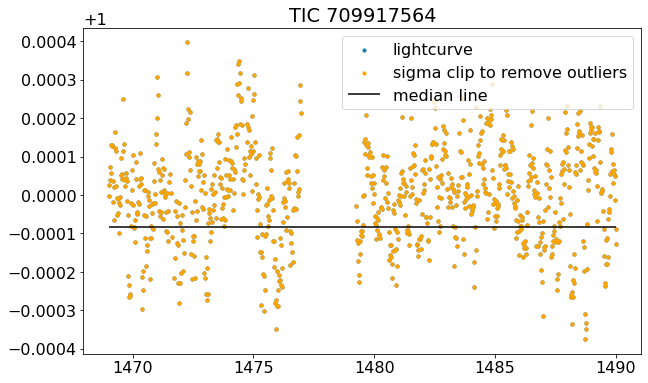

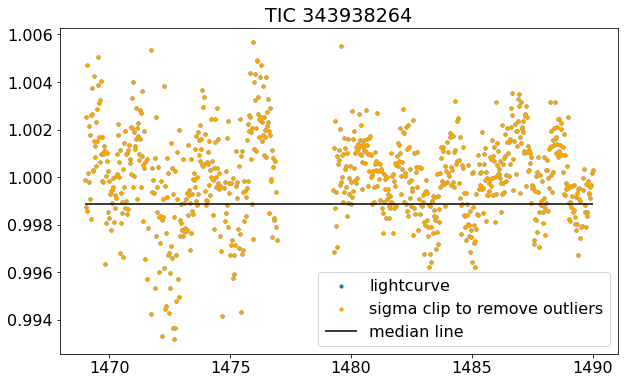

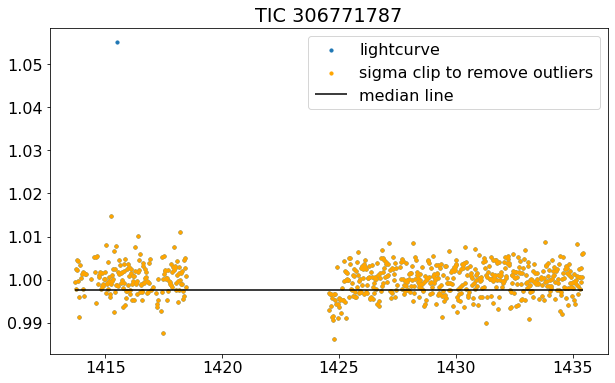

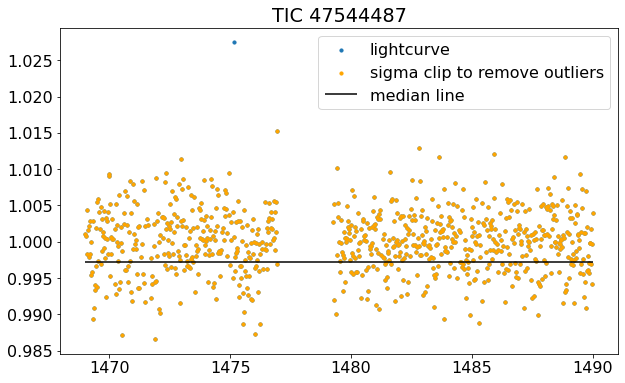

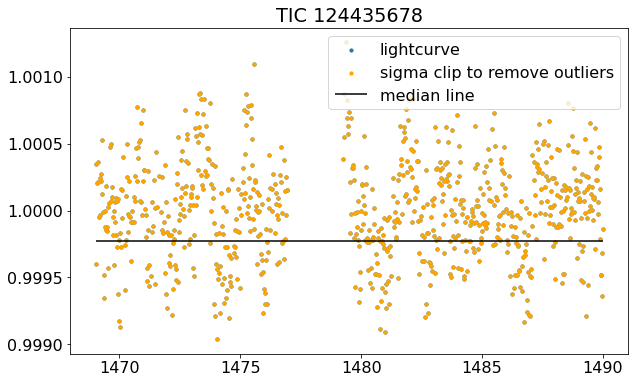

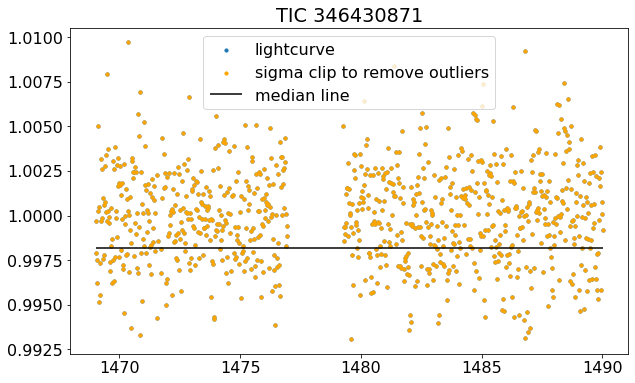

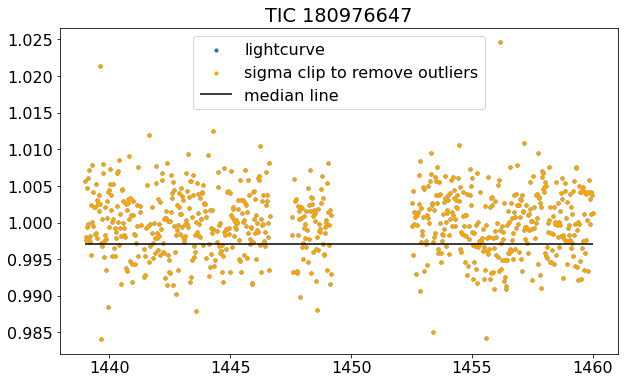

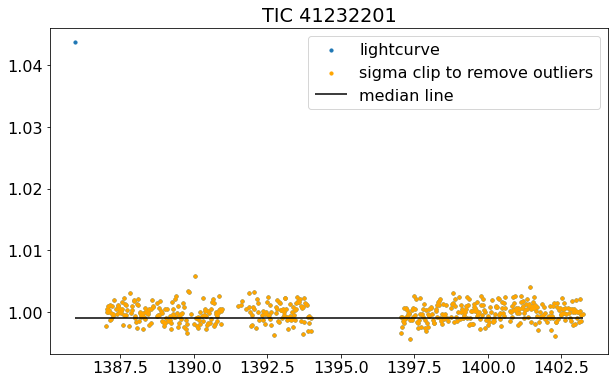

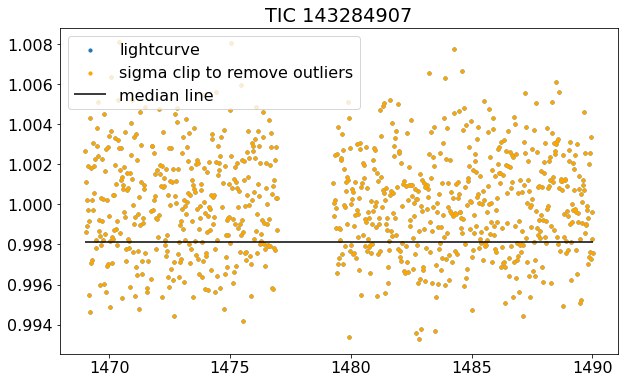

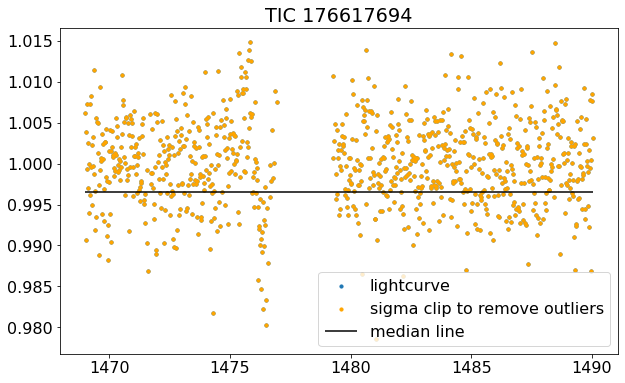

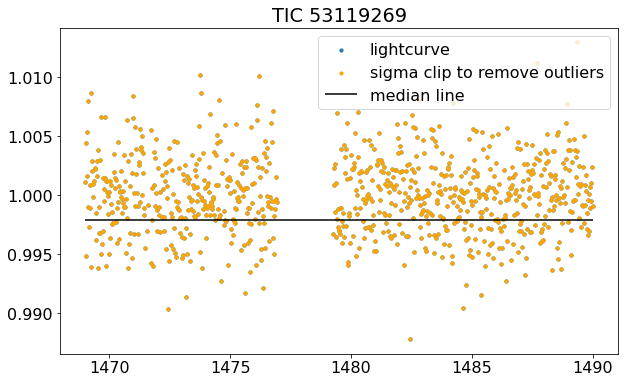

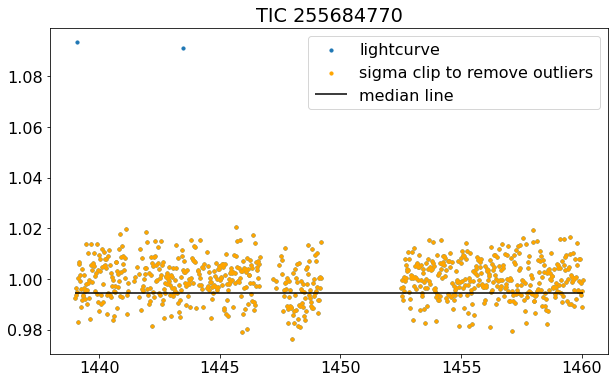

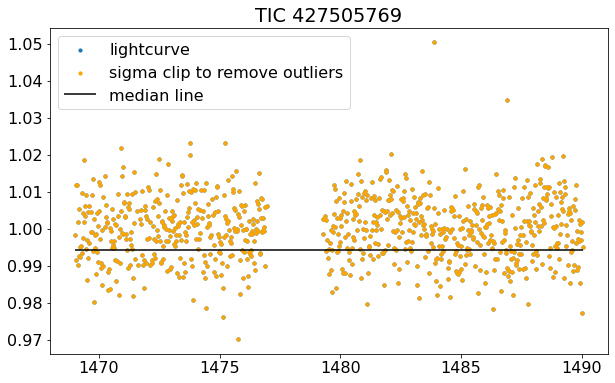

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7f87781789e0> (for post_execute):



KeyboardInterrupt



In [26]:
tic_file = []
for i in random.file:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=4,drop_bad_points=True)
    camera = store[4]
    tic = store[0]
    chip = store[5]
    fig,ax = plt.subplots(1,figsize=(10,6))
    med = np.nanmedian(normalise_lc(table['corrected flux']))
    mad = median_absolute_deviation(normalise_lc(table['corrected flux']),ignore_nan=True)
    sig_clip_array = sigma_clip(normalise_lc(table['corrected flux']),sigma=6)
    ax.scatter(table['time'],normalise_lc(table['corrected flux']),s=10,label='lightcurve')
    ax.scatter(table['time'],sig_clip_array,s=10,c='orange',label='sigma clip to remove outliers')
    ax.hlines(1-mad,xmin=table['time'][0],xmax=table['time'][-1],label='median line')
    ax.set_title(f"TIC {tic}")
    ax.legend()
    tic_file.append(random.file)
    

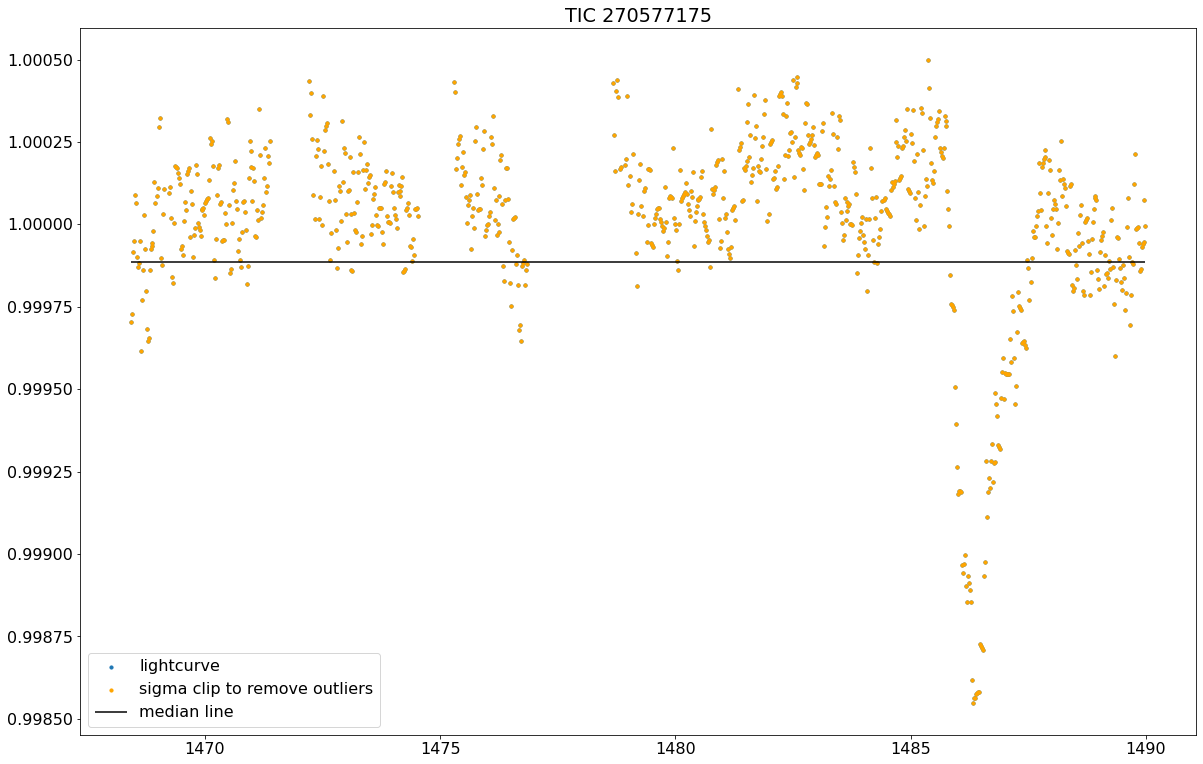

In [24]:
table = import_lightcurve('betapic/hlsp_qlp_tess_ffi_s0006-0000000270577175_tess_v01_llc.fits',drop_bad_points=True)
tic = 270577175
fig,ax = plt.subplots(1,figsize=(20,13))
med = np.nanmedian(normalise_lc(table['SAP_FLUX']))
mad = median_absolute_deviation(normalise_lc(table['SAP_FLUX']),ignore_nan=True)
sig_clip_array = sigma_clip(normalise_lc(table['SAP_FLUX']),sigma=6)
ax.scatter(table['TIME'],normalise_lc(table['SAP_FLUX']),s=10,label='lightcurve')
ax.scatter(table['TIME'],sig_clip_array,s=10,c='orange',label='sigma clip to remove outliers')
ax.hlines(1-mad,xmin=table['TIME'][0],xmax=table['TIME'][-1],label='median line')
ax.set_title(f"TIC {tic}")
ax.legend()

### Comparing twostep and onestep at LS power 0.08


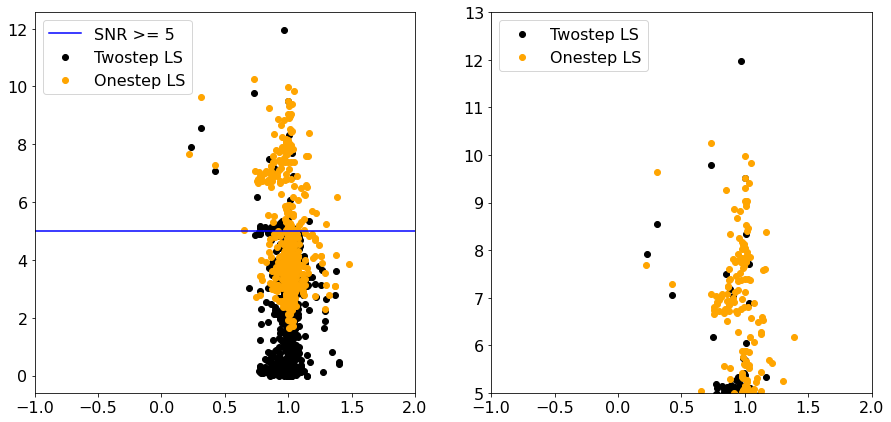

In [28]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].scatter(random.asym_score,abs(random['signal/noise']),c='black',label='Twostep LS')
ax[0].axhline(y=5, color='blue', linestyle='-',label='SNR >= 5')
ax[0].scatter(random_onestep.asym_score,abs(random_onestep['signal/noise']),c='orange',label='Onestep LS')
ax[0].set_xlim([-1,2])
ax[1].scatter(random.asym_score,abs(random['signal/noise']),c='black',label='Twostep LS')
ax[1].scatter(random_onestep.asym_score,abs(random_onestep['signal/noise']),c='orange',label='Onestep LS')
ax[1].set_ylim([5,13])
ax[1].set_xlim([-1,2])
ax[0].legend()
ax[1].legend()
plt.show()

In [34]:
maybetransits

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
9,tesslc_709917564.pkl,-7.937229e+00,-2.212374e+00,1475.744995,0.955850,0.696609,0.030666,0.937503,-0.000143,maybeTransit
11,tesslc_343938264.pkl,-8.033344e+00,-3.344549e+00,1475.324951,1.010187,0.445966,0.027018,0.708345,-0.002336,maybeTransit
12,tesslc_306771787.pkl,-8.169136e-01,-2.839986e-01,1471.760376,0.816694,0.001132,0.822894,0.166670,-0.003606,maybeTransit
13,tesslc_47544487.pkl,-5.598922e+00,-3.455134e+00,1475.848145,0.984424,0.000004,0.416030,1.041671,-0.003134,maybeTransit
15,tesslc_124435678.pkl,-6.153306e+00,-1.994867e+00,1475.973511,1.005082,0.170529,0.094132,0.333333,-0.000453,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
2063855,tesslc_93241063.pkl,-8.641665e-01,-3.334647e-01,1478.744141,1.001267,0.069994,0.103752,1.208316,-0.000500,maybeTransit
2063856,tesslc_37158402.pkl,-7.261650e+00,-3.937605e+00,1475.535522,1.004706,0.964712,0.068491,1.020828,-0.000241,maybeTransit
2063858,tesslc_150162929.pkl,-7.011710e+00,-2.533864e+00,1480.865234,0.989510,0.242675,0.072771,0.458334,-0.000452,maybeTransit
2063859,tesslc_39220951.pkl,-5.300000e-07,-1.600000e-07,1477.515991,0.992991,0.407849,0.153643,1.041654,-0.001491,maybeTransit


### Comparing twostep and onestep at LS power 0.05
- `random_05`: twostep at 0.05
- `random_onestep_05`: onestep at 0.05

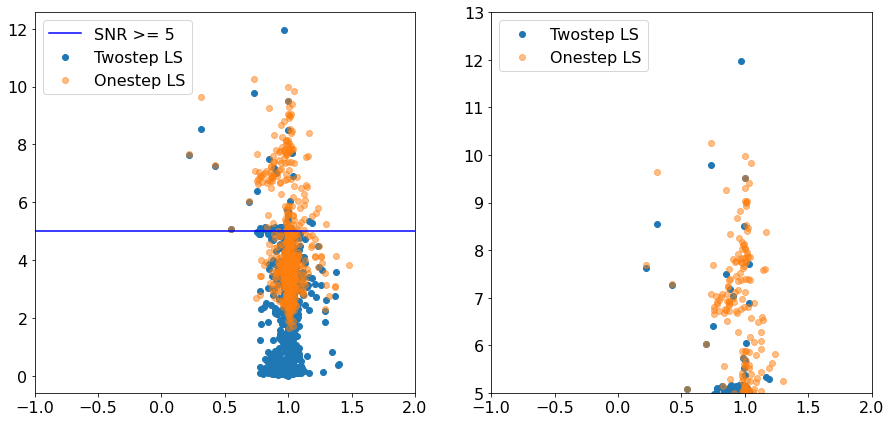

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].scatter(random_05.asym_score,abs(random_05['signal/noise']),label='Twostep LS')
#plt.scatter(random_onestep.asym_score,random_onestep['signal/noise'])
ax[0].axhline(y=5, color='blue', linestyle='-',label='SNR >= 5')
ax[0].scatter(random_onestep_05.asym_score,abs(random_onestep_05['signal/noise']),label='Onestep LS',alpha=0.5)
ax[0].set_xlim([-1,2])
ax[1].scatter(random_05.asym_score,abs(random_05['signal/noise']),label='Twostep LS')
#plt.scatter(random_05.asym_score,random_05['signal/noise'])
ax[1].scatter(random_onestep_05.asym_score,abs(random_onestep_05['signal/noise']),label='Onestep LS',alpha=0.5)
ax[1].set_ylim([5,13])
ax[1].set_xlim([-1,2])
ax[0].legend()
ax[1].legend()
plt.show()

### Comparing Twostep LS at 0.08 and 0.05

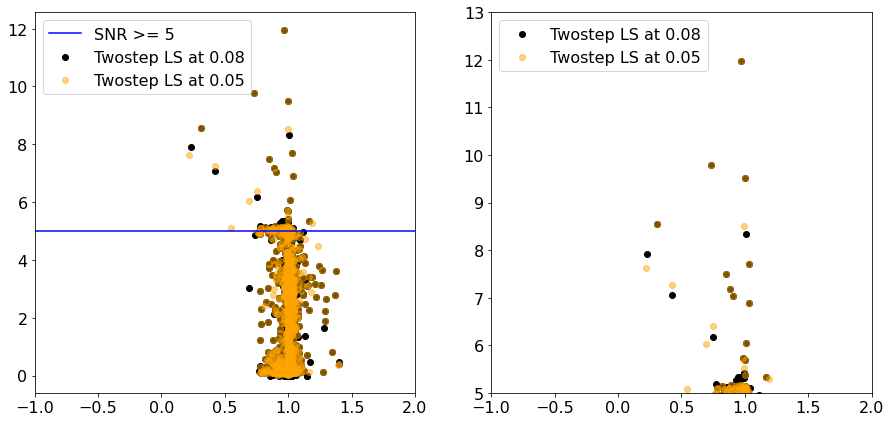

In [27]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].scatter(random.asym_score,abs(random['signal/noise']),c='black',label='Twostep LS at 0.08')
#plt.scatter(random_05.asym_score,random_05['signal/noise'])
ax[0].axhline(y=5, color='blue', linestyle='-',label='SNR >= 5')
ax[0].scatter(random_05.asym_score,abs(random_05['signal/noise']),c='orange',label='Twostep LS at 0.05',alpha=0.5)
ax[0].set_xlim([-1,2])
ax[1].scatter(random.asym_score,abs(random['signal/noise']),c='black',label='Twostep LS at 0.08')
#plt.scatter(random_05.asym_score,random_05['signal/noise'])
ax[1].scatter(random_05.asym_score,abs(random_05['signal/noise']),c='orange',label='Twostep LS at 0.05',alpha=0.5)
ax[1].set_ylim([5,13])
ax[1].set_xlim([-1,2])
ax[0].legend()
ax[1].legend()
plt.show()

### Comparing Onestep LS at 0.08 and 0.05

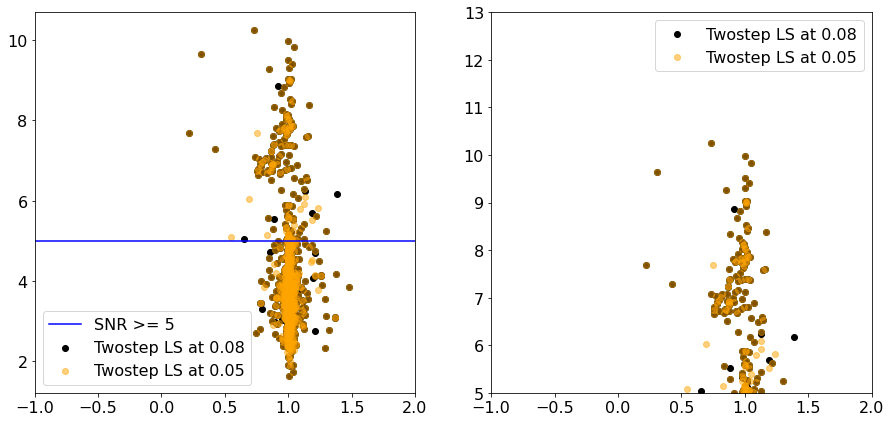

In [30]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].scatter(random_onestep.asym_score,abs(random_onestep['signal/noise']),c='black',label='Twostep LS at 0.08')
#plt.scatter(random_05.asym_score,random_05['signal/noise'])
ax[0].axhline(y=5, color='blue', linestyle='-',label='SNR >= 5')
ax[0].scatter(random_onestep_05.asym_score,abs(random_onestep_05['signal/noise']),c='orange',label='Twostep LS at 0.05',alpha=0.5)
ax[0].set_xlim([-1,2])
ax[1].scatter(random_onestep.asym_score,abs(random_onestep['signal/noise']),c='black',label='Twostep LS at 0.08')
#plt.scatter(random_05.asym_score,random_05['signal/noise'])
ax[1].scatter(random_onestep_05.asym_score,abs(random_onestep_05['signal/noise']),c='orange',label='Twostep LS at 0.05',alpha=0.5)
ax[1].set_ylim([5,13])
ax[1].set_xlim([-1,2])
ax[0].legend()
ax[1].legend()
plt.show()

---